# Задача 5. Паром.

Получите accuracy > 0.88 на тестовом датасете. Можно пользоваться любым классификатором **из sklearn**. Ансамблями пользоваться можно.

### XtreemeGradientBoosting и нейронные сети запрещены. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
import warnings

warnings.filterwarnings("ignore")

In [2]:
RANDOM_SEED = 42

In [6]:
all_data = pd.read_csv("data/estonia-passenger-list.csv")

anonymized_data = all_data.drop(["Firstname", "Lastname", "PassengerId"], axis=1)

# ведем еще один новый параметр: возрастную группу пассажара
bins = [-1, 10, 20, 40, 60, np.inf]
labels = ["minor", "teenager", "young_adult", "adult", "senior"] 
anonymized_data["AgeGroup"] = pd.cut(anonymized_data["Age"], bins=bins, labels=labels)

cat_columns = ["Country", "Sex", "Category", "CountryUpd", "AgeGroup"]

# cat_columns = ["Sex", "Category", "CountryUpd", "Country"]

# cat_columns = ["Sex", "Category", "AgeGroup", "Country"]
real_columns = ["Age"]

In [7]:
data_train, data_test, y_train, y_test = train_test_split(
    anonymized_data.drop(["Survived"], axis=1),  # X
    anonymized_data["Survived"],  # y
    test_size=0.3,  # доля от всех записей
    random_state=1337,  # зерно
    stratify=anonymized_data["Survived"],
)

In [8]:
most_represented_countries = data_train.Country.value_counts()[data_train.Country.value_counts() > 10].index

# Введем доп. категорию для малопредставленных стран, но он лишь понижает точность
data_train["CountryUpd"] = data_train.Country.map(
    lambda x: x if x in most_represented_countries else "Other"
)
data_test["CountryUpd"] = data_test.Country.map(
    lambda x: x if x in most_represented_countries else "Other"
)

In [9]:
column_transformer = ColumnTransformer(
    transformers=[
        (
            "ohe",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            cat_columns,
        ),
        ("scaling", StandardScaler(), real_columns),
    ],
    remainder="passthrough",
)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       256
           1       0.63      0.41      0.50        41

    accuracy                           0.89       297
   macro avg       0.77      0.69      0.72       297
weighted avg       0.87      0.89      0.88       297

0.8855218855218855


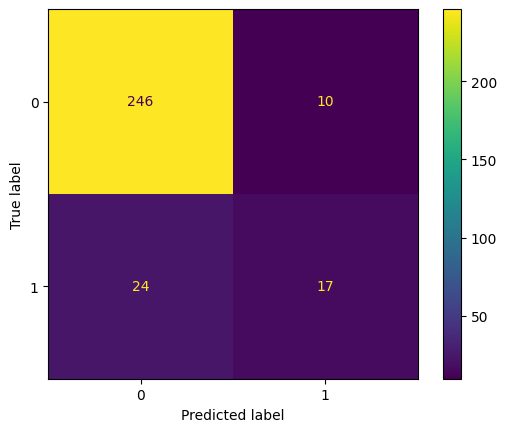

In [11]:
# Логистическая регрессия лишь понижает точность, от нее мы отказываемся
# log_pipeline = Pipeline(
#     steps=[
#         ("preprocessor", column_transformer),
#         (
#             "classifier",
#             LogisticRegression(random_state=RANDOM_SEED, class_weight="balanced"),
#         ),
#     ]
# )


# Была идея использовать только KNN, но если брать его отдельно, он переобучается и выдает только 1-ый класс
knn_pipeline = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            KNeighborsClassifier(
                n_neighbors=2, 
                weights="distance", 
                metric="euclidean",
                n_jobs=-1
            ),
        ),
    ]
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            RandomForestClassifier(
                class_weight={0: 0.35, 1: 0.65}, # веса получены эмпирически
                random_state=RANDOM_SEED,
                n_estimators=500,
            ),
        ),
    ]
)

sgd_pipeline = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            SGDClassifier(
                loss="log_loss",
                penalty="elasticnet",
                # class_weight='balanced',
                class_weight={0: 0.36, 1: 0.66},
                random_state=RANDOM_SEED,
            ),
        ),
    ]
)


voting_model = VotingClassifier(
    estimators=[
        ("knn", knn_pipeline),
        ("rf", rf_pipeline),
        ("sgd", sgd_pipeline),
        # ("log", log_pipeline),
    ],
    voting="soft",
)

y_pred = voting_model.fit(data_train, y_train).predict(data_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))

disp.plot()
plt.show()

In [7]:
param_grid = [
    {
        # Включать остальные параметры из сетки на свой страх и риск, они очень долго перебираются
        
        # "knn__classifier__n_neighbors": [2, 3, 5],
        # "rf__classifier__n_estimators": [10, 100, 200],
        # "rf__classifier__class_weight": [
        #     "balanced",
        #     {0: 0.45, 1: 0.55},
        #     {0: 0.6, 1: 0.8},
        # ],
        "log__classifier__C": [0.01, 0.1, 1.0],
    }
]

In [ ]:
clf = GridSearchCV(
    voting_model,
    param_grid,
    cv=3,    
    scoring="accuracy",
)
clf.fit(data_train, y_train)
y_true, y_pred = y_test, clf.best_estimator_.predict(data_test)

print(f"Best hyperparameters on the dev set:\n{clf.best_params_}")
print(classification_report(y_true, y_pred))
print(f"Accuracy: {np.round(accuracy_score(y_true, y_pred), decimals=3)}") # Не сильно понимаю, почему best_params_ не совпадают с теми, что были выше
print()
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))

disp.plot()
plt.show()

# Задача 6. Линрег

Допустим, у вас есть два множества **A** и **B** точек на плоскости. Линейная регрессия на плоскости -- это 
просто прямая, ее можно представить как функцию $ y = ax + b$.

Линейная регрессия, обученная на множестве **А**, имеет коэффициент **$a > 0$**. То же самое верно и для линейной регрессии, обученной на множестве **B**. Правда ли, что если обучить линейную регрессию на множестве $A \cup B$, то у полученной прямой коэффициент **a** будет больше 0?

Если да -  докажите, если нет - постройте контрпример.

**Ответ:** Нет, не правда. Действительно, если датаесет состоит из двух скоплений точек, которые мы обозначим $A$ и $B$, то мы получим, что возможен следующий исход:

Коэффициент линейной регрессии для А: 0.56
Коэффициент линейной регрессии для B: 0.442
Коэффициент линейной регрессии для АUB: -0.591


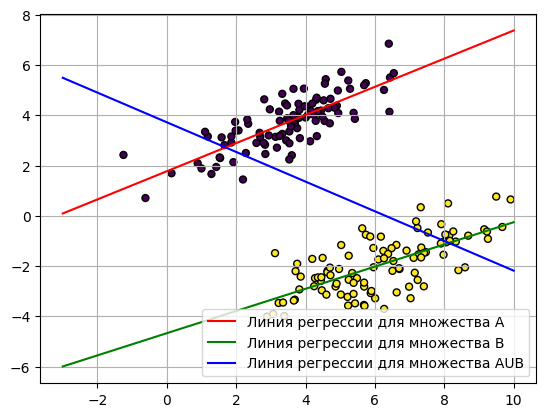

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression


X1, Y1 = make_blobs(
    n_samples=200, n_features=2, centers=[(0, 4), (8, -2)], cluster_std=1.0
)
X1 = np.matmul(X1, np.array([[1, 0], [1, 1]]))
X_A = X1[Y1 == 0]
X_B = X1[Y1 == 1]

reg_A = LinearRegression().fit(X_A[:, 0].reshape(-1, 1), X_A[:, 1])
reg_B = LinearRegression().fit(X_B[:, 0].reshape(-1, 1), X_B[:, 1])
reg_AB = LinearRegression().fit(X1[:, 0].reshape(-1, 1), X1[:, 1])


plt.subplot()
X = np.linspace(-3, 10)
plt.plot(
    X, reg_A.predict(X.reshape(-1, 1)), c="r", label="Линия регрессии для множества A"
)
plt.plot(
    X,
    reg_B.predict(X.reshape(-1, 1)),
    c="green",
    label="Линия регрессии для множества B",
)
plt.plot(
    X,
    reg_AB.predict(X.reshape(-1, 1)),
    c="blue",
    label="Линия регрессии для множества АUB",
)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")
plt.grid()
plt.legend()
print(f"Коэффициент линейной регрессии для А: {np.round(reg_A.coef_, decimals=3)[0]}")
print(f"Коэффициент линейной регрессии для B: {np.round(reg_B.coef_, decimals=3)[0]}")
print(
    f"Коэффициент линейной регрессии для АUB: {np.round(reg_AB.coef_, decimals=3)[0]}"
)

На графике видно, что пусть линии регрессии множеств $А$ и $B$ имеют положительные коэффициенты, линия регрессии множества $A \cup B$ имеет отрицательный коэффициент. Данный эффект называют **Парадоксом Симпсона**.